In [2]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
import pickle

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [3]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=(), config=0) #CHECK
    config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), 
                                         hidden_units=(2000,), config=0)
    config.replay_fn = lambda: Replay(memory_size=int(4e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 3e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    return agent
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [4]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[], choice=0)

In [10]:
weights = torch.load('../storage/24-300000-avdsr.weights', map_location='cpu').state_dict()
avdsr.network.load_state_dict(weights,strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
with open('../storage/15-loss.p', 'rb') as f:
    loss_vec = pickle.load(f)
kernel = 200
plt.figure(figsize=(6,4), dpi=100)
plt.plot(convolve(loss_vec, kernel))
plt.title('Loss during unsupervised learning phase, smoothing=' + str(kernel)) 
plt.xlabel('batch index'), plt.ylabel('$\psi(s,a,s\')$')
plt.show()

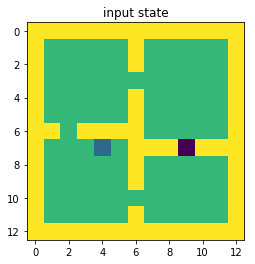

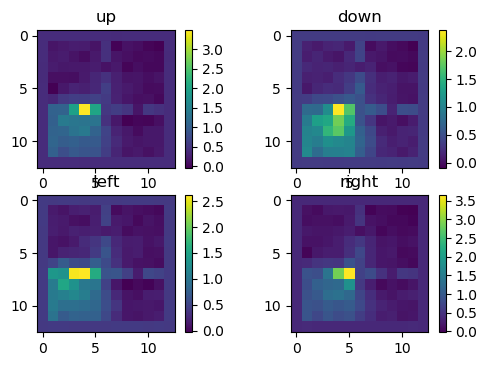

In [16]:
from deep_rl.component.fourrooms import *
g = [21, 28, 84, 91]
env = FourRoomsMatrix(layout='4rooms')
state = env.reset(init=60)
# env = FourRoomsMatrix(layout='3rooms')
# state = env.reset(init=40)
# env.current_cell = (3,2)
# state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))
# plt.imshow(state.reshape((13,13))), plt.show()

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()


In [ ]:
from deep_rl.component.fourrooms import *
env = FourRoomsMatrix(layout='3rooms')
g = [21, 28, 84, 91]
state = env.reset(init=40)
# env.current_cell = (3,2)
# state, _, _, _ = env.step(env.action_space.sample())
plt.imshow(env.render()); plt.title('input state'), plt.show()
_, out, _ = avdsr.network(tensor(state).unsqueeze(0))
# plt.imshow(state.reshape((13,13))), plt.show()

dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}

plt.figure(dpi=100)
psi = out.detach().cpu().numpy()
for i in range(4):
    psi_a = psi[0,i,:]
    plt.subplot(2,2,i+1)
    plt.imshow(psi_a.reshape((13,13)))
    plt.title(dirs[i])
    plt.colorbar()

plt.show()

In [47]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[], choice=0)
weights = torch.load('../storage/15-300000-avdsr.weights', map_location='cpu').state_dict()
avdsr.network.load_state_dict(weights,strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [44]:
avdsr.network

SRNetCNN(
  (body): SRIdentityBody()
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (layers): ModuleList(
    (0): Linear(in_features=2048, out_features=2000, bias=True)
    (1): Linear(in_features=2000, out_features=676, bias=True)
  )
  (psi2q): Psi2QNet()
)